## Знакомство с многомерной линейной регрессией 🧮
Линейная регрессия — один из самых простых и широко используемых методов, используемых для анализа данных и прогнозирования. Она позволяет моделировать линейные зависимости между переменными, представляя её в виде прямой линии. 
* Основная цель линейной регрессии — предсказать значение зависимой переменной на основе независимых, называемых факторами или более модно - фичами. 

Однако, линейная регрессия не так проста и бывает разных видов:
- 📏 _"Простая" линейная регрессия_ - регрессия с одним признаком
- 🧮 _"Многомерная" линейная регрессия_ - регрессия с несколькими признаками
- 🌀 _"Полиноминальная" регрессиия_ - регрессия с несколькими признаками + степени этих признаков (полином)
- 📊 _"Регрессия Пуассона"_ - модель линейной регресси, которая лучше работает когда целевая переменная — счётные данные (число заказов, покупок, покупателей, ...)

Линейная регрессия является отличной отправной точкой (бейзлайном) перед построением или сравнением с более сложными моделями. 

В этом ноутбуке мы познакомимся с моделью многомерной регрессии с несколькими признаками.

In [1]:
import numpy as np
import pandas as pd
import warnings

warnings.filterwarnings('ignore')

## Данные 📊
При изучении чего-либо я сторонник использовать подход от простого к сложному, поэтому данные будут очень простыми - всего пара столбцов и немного строк. Будем работать с данными о рекламе и продажах. У нас есть 200 рынков, на каждом из них мы инвестировали в разную рекламу какую-то сумму и получили продажи `Sales`

- `TV` - доллары, потраченные на ТВ рекламу для одного продукта на данном рынке (в тысячах)
- `Radio` - доллары, потраченные на радио рекламу
- `Newspaper` - доллары, потраченные на рекламу в газетах
- `Area` - в какой зоне происходила реклама (сельская, пригород, город)
- `Sales` - продажи одного продукта на данном рынке

Предсказывать мы будем продажи - это будет наша целевая переменная, остальные - объясняющие.

In [2]:
# загрузим данные
data = pd.read_csv('../data/regression/ads_data.csv')
data.head()

,TV,Radio,Newspaper,Sales,Area
0,230100.0,37800.0,69200.0,22100.0,suburban
1,44500.0,39300.0,45100.0,10400.0,urban
2,17200.0,45900.0,69300.0,9300.0,rural
3,151500.0,41300.0,58500.0,18500.0,rural
4,180800.0,10800.0,58400.0,12900.0,suburban


- Например, в первой строчке мы получили продажи в размере 22.1k $, вложив:
    - 230.1k $  в канал _TV_
    - 37.8k $ в _Radio_
    - 69.2k $ в _Newspaper_ в пригороде

## Регрессия со множеством признаков 📉

Многомерная линейная регрессия — это подход к прогнозированию *количественной переменной* с использованием *нескольких признаков*. 

$y = w_0 + w_1 x_1 + w_2 x_2 + \dots + w_n x_n$

Данное уравнение можно переписать в векторной форме:

$y = w_0 + \mathbf{W}^\top \mathbf{X}$

- $y$ — целевая переменная или *target* 
- $X = [x_1, x_2, \dots, x_n]$ — вектор признаков
- $W = [w_1, w_2, \dots, w_n]$ — вектор весов (коэффициентов при признаках)  
- $w_0$ — свободный член или *bias*

Чтобы создать модель, мы должны "выучить" значения этих коэффициентов. И как только мы "выучим" эти коэффициенты, мы сможем использовать модель для прогнозирования. В конспекте я упоминал, что найти веса модели можно 2-мя способами:
- 🧠 _Аналитическое решение_ - просто используем формулу
- ⚙️ _Численное решение_ - используем градиентный спуск

In [3]:
# взглянем на доступные признаки
print('Признаки:', data.columns.to_list())

Признаки: ['TV', 'Radio', 'Newspaper', 'Sales', 'Area']


- Признак `Area` является категориальным, я еще не рассказывал как работать с категориями в моделях, поэтому для упрощения пока не будем включать данный признак.

In [4]:
# исключим признак "Area"
columns = data.drop(columns=['Area'], axis=1).columns.to_list()
print('Используемые признаки:', columns)

Используемые признаки: ['TV', 'Radio', 'Newspaper', 'Sales']


In [5]:
from sklearn.model_selection import train_test_split

features = data[columns].drop(columns=['Sales']).columns.to_list()
target = 'Sales'

# также не забудем разделить выборку на train/test в пропроции 80/20
X_train, X_test, y_train, y_test = train_test_split(
    data[features], data[target], test_size=0.2, random_state=42, shuffle=True
)

# проверим размерности полученных данных
print('Кол-во наблюдений (Train) -> ', X_train.shape[0])
print('Кол-во наблюдений (Test) -> ', X_test.shape[0])

Кол-во наблюдений (Train) ->  160
Кол-во наблюдений (Test) ->  40


- Получили 160 строчек/наблюдений в train и 40 в test: это соответствует пропорции нашего разбиения.

## Аналитическое решение 🧠
Теперь рассмотрим модель с несколькими признаками:

**Модель**

$y = w_0 + w_1 x_1 + w_2 x_2 + \dots + w_n x_n$

**Функция потерь**

$$
MSE = \frac{1}{n} \sum_{i=1}^n (y_i - \hat y_i)^2 =  \frac{1}{n} \sum_{i=1}^n (y_i - (w_0 + w_1 x_1 + w_2 x_2 + \dots + w_n x_n))^2 \to \min_{w}
$$

$$
MSE = \| \mathbf{y-W^TX} \|_2^2 \rightarrow \min_{w}
$$

Находим оптимальное $w$, взяв производную по $W$ и приравняв её к нулю:


$$
\frac{\partial MSE}{\partial \mathbf{W}} = -\frac{2}{n} \mathbf{X}^\top (\mathbf{y} - \mathbf{XW}) = 0
$$

**Решение**
$$
\mathbf{W} = (\mathbf{X}^\top \mathbf{X})^{-1} \mathbf{X}^\top \mathbf{y}
$$

**Важно** ⚠️
- Аналитическое решение выше имеет условие существования: матрица $\mathbf{X}^\top \mathbf{X}$ должна быть обратима и невырожденной (т.е. не иметь в идеале линейной зависимости между признаками).
- Уравнение выше называется _"нормальное уравнение"_, являющиеся классическим решением для задачи линейной регресии со множством признаков.
- Я не стал показывать как получаются частные производные по каждому из аргументов, а сразу записал градиент в матричном виде.

In [6]:
# решим аналитически, предварительно трансформировав данные в вектора
X = X_train.values                 # матрица объекты-признаки (n, m)
y = y_train.values.reshape(-1, 1)  # вектор-столбец 

# добавим столбец единиц для bias
X = np.hstack([np.ones((X.shape[0], 1)), X])

# вычисляем веса по формуле нормального уравнения
XTX_inv = np.linalg.inv(X.T @ X)
W = XTX_inv @ X.T @ y

print("Коэффициенты модели:", W.flatten())

Коэффициенты модели: [2.97906734e+03 4.47295175e-02 1.89195054e-01 2.76111434e-03]


## Пару слов про библиотеки 📚
Для обучения большинства ML-моделей достаточно использования [sklearn](https://scikit-learn.org/stable/index.html). Однако, есть еще одна удобная библиотека которая также часто используется - [statsmodels](https://www.statsmodels.org/stable/index.html).
- _Sklearn_ больше направлен на "прикладной" ML - обучение моделей, их валидация и усовершенствование
- _Statsmodels_ больше про статистику и интерпретацию моделей. В нем зашит автоматический расчет доверительных интервалов, значимости коэффициентов и много другое. Основной акцент сделан на интерпретации модели с статистичейской точки зрения

И формат с точки зрения кода немного отличается, поэтому _statsmodels_ требует небольшого привыкания. Так как _sklearn_ очень часто используется при обучении ML-моделей, то мы именно на нем и сфокусируемся! _Statsmodels_ будет рассмотрен в дополнительных уроках.

In [7]:
# теперь решим с использованием модели из модуля sklearn
from sklearn.linear_model import LinearRegression

# объявляем модель
regression_model = LinearRegression()

# обучаем модель на тренировочных данных
regression_model.fit(X_train, y_train)

# смотри на полученные коэффициенты
print("Коэффициенты модели:", regression_model.coef_)
print("Смещение (intercept/bias):", regression_model.intercept_)

Коэффициенты модели: [0.04472952 0.18919505 0.00276111]
Смещение (intercept/bias): 2979.067338122635


- Полученные веса совпадают, значит мы все сделали верно!
- В метод `fit()` необходимо передать `DataFrame` или матрицу, так как [_sklearn_](https://scikit-learn.org/stable/index.html) ожидает двумерную матрицу признаков формата *(n_samples, n_features)*. Это нормально, так как ML алгоритмы эффективнее обучаются при использовании векторов и матриц!

In [8]:
# пример обучения, используя матрицы
X_train_matrix = X_train.values
X_test_matrix = X_test.values

y_train_matrix = y_train.values.reshape(-1, 1)
y_test_matrix = y_train.values.reshape(-1, 1)
print('Размерность матрицы признаков X (Train) -> ', X_train_matrix.shape)
print('Размерность матрицы признаков X (Test) -> ', X_test_matrix.shape)

Размерность матрицы признаков X (Train) ->  (160, 3)
Размерность матрицы признаков X (Test) ->  (40, 3)


In [9]:
regression_model.fit(X_train_matrix, y_train_matrix)
print("Коэффициенты модели:", regression_model.coef_)
print("Смещение (intercept/bias):", regression_model.intercept_)

Коэффициенты модели: [[0.04472952 0.18919505 0.00276111]]
Смещение (intercept/bias): [2979.06733812]


- Результат также совпадает 🎉 
- Теперь проверим качество модели - как сильно она ошибается.

In [10]:
from sklearn.metrics import mean_squared_error

# измеряем качество на обучении (train) и тестовых данных (test)
preds_train = regression_model.predict(X_train_matrix)
preds_test = regression_model.predict(X_test_matrix)

# измеряем ошибки
mse_train = mean_squared_error(y_train, preds_train)
mse_test = mean_squared_error(y_test, preds_test)

print('MSE (Train) -> ', mse_train)
print('MSE (Test) -> ', mse_test)

MSE (Train) ->  2705129.4230814143
MSE (Test) ->  3174097.3539761053


- Получили ошибку в 2 **квадратных миллионов долларов** на обучающей выборке (train) и 3 квадратных миллионов долларов на тестовой выборке (test). Анализировать квадратные миллионы долларов не очень понятно, особенно если необходимо предоставить результаты бизнесу или твоему начальнику, лиду, ... 
- Для избавления от квадратов используют квадрат из среднеквадратичной ошибки - ["Root Mean Squared Error"](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.root_mean_squared_error.html). Данную метрику можно вычислить при помощи все той же метрик `mean_squared_error`, указав параметр `squared=False`

In [11]:
from sklearn.metrics import root_mean_squared_error as rmse

# измеряем ошибки (без квадратов, используя RMSE)
rmse_train = rmse(y_train, preds_train)
rmse_test = rmse(y_test, preds_test)

print('RMSE (Train) -> ', rmse_train)
print('RMSE (Test) -> ', rmse_test)

RMSE (Train) ->  1644.7277656443373
RMSE (Test) ->  1781.5996615334504


- Модель ошибается на 1644$ на обучающей выборке, и на 1781$ на тестовой. Много это или мало мы должны решить на основании бизнес требований. Однако пока это не является нашей целью.  

### Интерпретация коэффициентов модели 🔍
Отлично, ты обучил модель и теперь знаешь чему равны коэффициенты `W`. С математической точки зрения твоя модель имеет следующий вид:

$$
y = 2979.067 + 0.045TV + 0.189Radio + 0.003Newspaper 
$$

Известно, что одним из преимуществ линейных моделей является их интерпретируемость. Как интерпретировать данную модель? 🤔 Ну, так как модель линейная, то и признаки интерпретируются соответствующим образом:

> Коэффициент при признаке `w` показывает, насколько изменится целевая переменная `y` при изменении признака `x` на единицу, при условии, что другие коэффиценты зафиксированы (неизменны):

- Если `w > 0`: увеличение `x` приводит к росту `y` (прямая зависимость)
- Если `w < 0`: увеличение `x` приводит к уменьшению `y` (обратная зависимость)
- Если `w = 0`: зависимости нет (признак никак не влияет на таргет)

В нашем случае, все коэффициенты положительны, значит они все положительно влияют на целевую переменную. Признак _"Radio"_ имеет самый большой вес, а значит сильнее всего влияет на продажи:

> C каждого проинвестированного доллара в рекламу на Radio мы получаем 0.2 долларов продаж.

Однако, спешу тебя огорчить - это неверная интерпретация 😭. Напоминаю, что теперь мы используем не 1 признак, а множество. Это множество признаков имеет разный масштаб, который в свою очередь сказывается на важности признаков. Оказывается, что когда масштаб разный, то модель линейной регрессии пытается скомпенсировать разницу масштаба с помощью значения коэффициентов модели! То есть, признак с большим масштабом (размахом/разбросом значений) может получить маленький коэффициент — просто потому, что он может принимать очень большие/маленькие значения. 

Ранее, мы сказали, что признак "Radio" является самым важным. Но это неверно, так как мы не масштабировали нашу выборку, а значит не можем доверять значениям коэффициентов! Если ты все еще мне не веришь, то я могу это доказать, используя корреляцию.

In [13]:
train_df = pd.concat([X_train, y_train], axis=1)
train_df.corr(method='spearman').style.background_gradient(cmap='coolwarm')

,TV,Radio,Newspaper,Sales
TV,1.000000,0.063269,-0.003842,0.777709
Radio,0.063269,1.000000,0.344456,0.585401
Newspaper,-0.003842,0.344456,1.000000,0.168320
Sales,0.777709,0.585401,0.168320,1.000000


Что и требовалось доказать, признак _"TV"_ сильнее коррелирует с _"Sales"_ чем _"Radio"_. Поэтому не может быть такого, что _"Radio"_ важнее

## Градиентный спуск ⛰️
Аналитическое решение - это неплохо. Однако его не всегда можно применить + у него есть недостатки, например, очень медленный при большом числе признаков. В таких случаях "спасает" метод градиентного спуска:

1. Инициализируем случайно значение w_0
2. Находим производную функции потерь $\frac{\partial L}{\partial w}$
3. До тех пор, пока $|w_{t + 1} - w_t| > \varepsilon$ делаем шаги

$$
w_{t+1} = w_t - \eta_t \cdot \frac{\partial L}{\partial w}
$$

В качестве скорости обучение, $\eta_t$, можно взять какую-нибудь малую константу. Например, $0.001$, либо подобрать это значение более умным образом - делить на номер шага/итерации.

In [18]:
# функция градиента MSE по w
def calculate_gradient_mse(
    X: np.ndarray, y: np.ndarray, y_pred: np.ndarray
) -> np.ndarray:
    return -2 * X.T @ (y - y_pred) / y.shape[0]

In [19]:
# данные в виде векторов/матриц
X = X_train.values  # матрица размерности (n_samples, n_features)
y = y_train.values  # вектор размерности (n_samples)

# добавим bias (столбец из единиц) к признакам
X = np.hstack([np.ones((X.shape[0], 1)), X]) # (n_samples, n_features + 1)

# инициализация
n_features = X.shape[1]
W = np.zeros(n_features)           # начальные веса (вектор)
weights_history = [W.copy()]       # история весов
mse_history = []                   # история ошибок
eta = 1e-6                         # скорость обучения
eps = 1e-7                         # порог останова
weights_diff = np.inf              # изначально большая разница
i = 0                              # итератор
show_loss = True

# логика алгоритма (градиентный спуск)
while weights_diff > eps:

    # прогнозируем
    y_pred = X @ W

    # вычисляем MSE
    mse = np.mean((y - y_pred) ** 2)

    # вычисляем градиент ошибки
    mse_grad = calculate_gradient_mse(X, y, y_pred)

    # вычисляем новые веса (формула градиентного спуска)
    w_new = W - eta * mse_grad

    # вычисляем раницу между весами (чтобы понимать когда останавливать алгоритм градиентного спуска)
    weights_diff = np.linalg.norm(w_new - W)  # разница между старыми и новыми весами (норма вектора)
    
    # сохраянем веса модели и ошибку
    weights_history.append(w_new.copy())
    mse_history.append(mse)

    W = w_new
    i += 1

    if show_loss and i % 10 == 0:
        print(f'MSE -> {mse:.6f}')

# результат
print('\nЧисло итераций (Градиентный Спуск): ', len(weights_history))
print('Оптимальные веса: ', weights_history[-1])


MSE -> 31954640492053717211100963315892517719503414239389838292887213145617964661609521337463969153024.000000
MSE -> 18790062148381892509622889840029783669805426182522240843991092019017677219758620065569205170196887721845528690772107497961987949094229197897517024305094687744952046759780658370624210205671424.000000
MSE -> 11048987881051329412442528912985273207259607989174639645937660015174377460809323510709171511270876522842324554240229584765473846051598197156410694732819990063746527371067123121276268024992352967450531079710591170950466677278492769168750634230025004594907919970118650556909317694800527360.000000
MSE -> inf
MSE -> inf
MSE -> inf

Число итераций (Градиентный Спуск):  65
Оптимальные веса:  [-inf  nan  nan -inf]


- Получили бесконечность, хмм 🤔. Что могло пойти не так? Скорее всего что-то не так на этапе обновления весов. Давай взглянем как изменялись веса модели и ошибка.

In [20]:
# как "взрывались" веса модели 💥
k = 5
print('Взрыв весов модели:')
print(weights_history[:k])

# как росла ошибка модели
print('\nРост ошибки модели:')
print(mse_history[:k])

Взрыв весов модели:
[array([0., 0., 0., 0.]), array([2.82000000e-02, 4.88959375e+03, 7.34142250e+02, 8.93585000e+02]), array([-1.55411705e+03, -3.02559012e+08, -3.67328987e+07, -4.77622977e+07]), array([9.53189935e+07, 1.85930996e+13, 2.24806377e+12, 2.92187727e+12]), array([-5.85640165e+12, -1.14241328e+18, -1.38114852e+17, -1.79508047e+17])]

Рост ошибки модели:
[np.float64(224746250.0), np.float64(7.745187505354819e+17), np.float64(2.9238692447185153e+27), np.float64(1.1038177346561198e+37), np.float64(4.1671275662635106e+46)]


Wow, наши веса очень сильно растут от итерации к итерации, то же самое происходит и с ошибкой модели. На каждой итерации веса становятся все больше и больше, это приводит к очень большим предсказаниям и большой ошибке, которую мы еще возводим в квадрат. Такие значения просто не помещаются в тип данных `float`, что приводит к появлению бесконечности. Получается, что вместо минимизации алгоритм совершает максимизацию. А это нам не нужно! Проблема связана с разным масштабом признаков модели ☝️

In [21]:
for feature in features:
    print(f'\nДиапазон изменения переменной "{feature}":')
    print(f'[{X_train[feature].min()} - {X_train[feature].max()}]')


Диапазон изменения переменной "TV":
[700.0 - 296400.0]

Диапазон изменения переменной "Radio":
[0.0 - 49600.0]

Диапазон изменения переменной "Newspaper":
[300.0 - 100900.0]


## 📏 Проблема разного масштаба признаков
- Максимум признака `TV` ≈ 296 400, если округлить, то получим ≈ 300 000
- Максимум признака `Radio` ≈ 49 600 → округлённо ≈ 50 000
- Максимум признака `Newspaper` ≈ 100 900 → округлённо ≈ 101 000
- Максимум признака `Sales` ≈ 27 000 → округлённо ≈ 30 000

Например, признак `TV` примерно в 10 раз больше, чем `Sales` — разница в один порядок (10¹). Этого уже достаточно чтобы алгоритм перестал сходиться, и вот почему: если взглянуть на формулу градиента линейной регресии:

$$
\nabla_w \text{MSE} = -\frac{2}{n} \cdot \mathbf{X}^\top (\mathbf{y} - \mathbf{Xw})
$$

Здесь каждый признак $x_{ij}$ участвует **дважды**:
1. Внутри предсказания $\mathbf{XW}$
2. При домножении остатка $(\mathbf{y} - \mathbf{Xw})$ на $ \mathbf{X}^\top$

В нашем случае при умножении $\mathbf{XW}$ мы получим очень большое число -> большой остаток. Затем при умножении остатка на $\mathbf{X}^\top$ снова получаем очень большое число (большой градиент). Все это приводит к тому, что обновление весов по формуле градиентного спуска:
$$
w_{t+1} = w_t - \eta_t \cdot \frac{\partial L}{\partial w}
$$

станет нестабильным даже при сколь угодно малых значениях 𝜂. Веса начнут "взрываться" 💥 — уходить в inf/nan, и алгоритм перестанет обучаться (будет расходиться). Поэтому необходим масштабировать признаки, это приводит к тому, что все столбцы матрицы $X$ изменяются примерно в одном диапазоне: $[0, 1]$ или $[-1, 1]$. Как следствие:
- Произведение $\mathbf{XW}$ больше не "взрывается"
- Остатки умеренные
- Градиенты становятся небольшими и стабильными

In [22]:
from sklearn.preprocessing import StandardScaler

# произведем масштабирование
scaler_features = StandardScaler()
scaler_target = StandardScaler()

X_train_scaled = scaler_features.fit_transform(X_train)
X_test_scaled = scaler_features.transform(X_test)

y_train_scaled = scaler_target.fit_transform(y_train.to_frame())
y_test_scaled = scaler_target.transform(y_test.to_frame())

- Метод `.fit_transform()` в `StandardScaler` ожидает матрицу на входе, поэтому я преобразовал `y_train` в `DataFrame`. Можно было преобразовать и в матрицу, используя NumPy

In [23]:
print('Отмасштабированные значения признака "TV":')
print(X_train_scaled[:k, 0].reshape(-1))

print('\nОтмасштабированные значения таргета "Sales":')
print(y_train_scaled[:k].reshape(-1))

Отмасштабированные значения признака "TV":
[-0.40424839  0.32060772 -1.27051084 -1.04235941  0.8791034 ]

Отмасштабированные значения таргета "Sales":
[-0.60870673 -0.25526411 -0.78542804 -0.86397084 -0.49089252]


Можно заметить, что появились отрицательные значения. Это нормально, так как `StandardScaler` масштабирует данные по формуле:

$$
x_{\text{scaled}} = \frac{x - \text{mean}(x)}{\text{std}(x)}
$$

- Значения меньше среднего становятся отрицательными, а больше среднего - положительными
- Также я отмасштабировал не только матрицу признаков `X`, но и таргет `y`. Если не масштабировать `y`, то получится сильный "перекос" градиента функции так как наш `X` изменяется в пределах от [-1, +1], а целевая переменная в десятках тысяч. Этого уже достаточно, чтобы снова получить проблемы при использовании градиентного спуска.

In [24]:
# # данные в виде векторов/матриц
X = X_train_scaled  # матрица размерности (n_samples, n_features)
y = y_train_scaled.flatten()  # вектор размерности (n_samples)

# добавим bias (столбец из единиц) к признакам
X = np.hstack([np.ones((X.shape[0], 1)), X]) # (n_samples, n_features + 1)

# инициализация
n_features = X.shape[1]
W = np.zeros(n_features)           # начальные веса (вектор)
weights_history = [0]              # история весов
mse_history = []                   # история ошибок
eta = 1e-3                         # скорость обучения
eps = 1e-7                         # порог останова
weights_diff = np.inf              # изначально большая разница
i = 0                              # итератор
show_loss = True

# логика алгоритма (градиентный спуск)
while weights_diff > eps:

    # прогнозируем
    y_pred = X @ W

    # вычисляем MSE
    mse = np.mean((y - y_pred) ** 2)

    # вычисляем градиент ошибки
    mse_grad = calculate_gradient_mse(X, y, y_pred)

    # вычисляем новые веса (формула градиентного спуска)
    W_new = W - eta * mse_grad

    # вычисляем раницу между весами (чтобы понимать когда останавливать алгоритм градиентного спуска)
    weights_diff = np.linalg.norm(W_new - W)  # разница между старыми и новыми весами (норма вектора)
    
    # сохраянем веса модели и ошибку
    weights_history.append(W_new)
    mse_history.append(mse)

    W = W_new
    i += 1

    if show_loss and i % 10 == 0:
        print(f'[{i}] MSE -> {mse:.6f}')

# результат
print('\nЧисло итераций (Градиентный Спуск): ', len(weights_history))
print('Оптимальные веса: ', weights_history[-1])


[10] MSE -> 0.964752
[20] MSE -> 0.927282
[30] MSE -> 0.891517
[40] MSE -> 0.857374
[50] MSE -> 0.824778
[60] MSE -> 0.793656
[70] MSE -> 0.763939
[80] MSE -> 0.735560
[90] MSE -> 0.708459
[100] MSE -> 0.682574
[110] MSE -> 0.657849
[120] MSE -> 0.634230
[130] MSE -> 0.611666
[140] MSE -> 0.590107
[150] MSE -> 0.569507
[160] MSE -> 0.549823
[170] MSE -> 0.531011
[180] MSE -> 0.513031
[190] MSE -> 0.495845
[200] MSE -> 0.479416
[210] MSE -> 0.463710
[220] MSE -> 0.448694
[230] MSE -> 0.434336
[240] MSE -> 0.420606
[250] MSE -> 0.407475
[260] MSE -> 0.394917
[270] MSE -> 0.382905
[280] MSE -> 0.371414
[290] MSE -> 0.360421
[300] MSE -> 0.349903
[310] MSE -> 0.339839
[320] MSE -> 0.330209
[330] MSE -> 0.320993
[340] MSE -> 0.312172
[350] MSE -> 0.303729
[360] MSE -> 0.295646
[370] MSE -> 0.287908
[380] MSE -> 0.280500
[390] MSE -> 0.273406
[400] MSE -> 0.266613
[410] MSE -> 0.260108
[420] MSE -> 0.253877
[430] MSE -> 0.247909
[440] MSE -> 0.242191
[450] MSE -> 0.236714
[460] MSE -> 0.2314

- Алгоритм сходится, количество итераций алгоритма зависит от параметров: `eta` и `eps`
- Полученный вес отличается от того что мы видели раньше, но это вполне ожидаемо так как теперь мы обучали модель на отмасштабированных данных!

In [25]:
from typing import List, Dict

# определим функцию для получения весов по признакам
def get_feature_weights_history(
    weights_history: List[np.ndarray],
    feature_names: List[str] = None
) -> Dict[str, List[float]]:
    """
    Преобразует историю весов модели в словарь вида:
        - {'feature': [...]}
    """
    # удаляем/заменяем некорректный первый элемент, если это просто 0
    if isinstance(weights_history[0], int) or isinstance(weights_history[0], float):
        weights_history[0] = np.zeros_like(weights_history[1])

    # преобразуем в матрицу: (n_iterations, n_features)
    weights_matrix = np.array(weights_history)

    # исключаем bias (первый столбец)
    weights_matrix = weights_matrix[:, 1:]
    
    n_features = weights_matrix.shape[1]

    # если имена признаков не заданы — создаем по умолчанию
    if feature_names is None:
        feature_names = [f'feature_{i}' for i in range(n_features)]

    weights_dict = {
        feature_names[i]: weights_matrix[:, i].tolist()
        for i in range(n_features)
    }

    return weights_dict

# преобразуем историю весов в словарь
feature_names = X_train.columns
weights_history_dict = get_feature_weights_history(
    weights_history=weights_history, feature_names=feature_names
)

In [26]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# создаём фигуру с двумя подграфиками
fig = make_subplots(
    rows=2, cols=1,
    shared_xaxes=True,               # общая ось X для обоих графиков
    vertical_spacing=0.1,            # расстояние между графиками
    subplot_titles=("Изменение весов модели", "Изменение ошибки MSE (Train)")
)

# добавляем график - "Изменения весов модели"
for feature, history in weights_history_dict.items():
    fig.add_trace(
        go.Scatter(
            y=history,
            mode='lines',
            name=feature,  # имя признака — попадёт в легенду и определяет цвет
        ),
        row=1, col=1
    )                  

# добавляем график - "Изменения ошибки"
fig.add_trace(
    go.Scatter(
        y=mse_history,                  # значения ошибок по оси Y
        mode='lines',                   # тип графика — линия
        name='MSE'
    ),
    row=2, col=1
)

# общие настройки макета графика
fig.update_layout(
    height=700, width=800,
    title_text="Динамика обучения модели (Градиентный спуск)",
    showlegend=True
)

# добавляем подписи осей
fig.update_xaxes(title_text="Номер итерации", row=2, col=1)
fig.update_yaxes(title_text="Вес", row=1, col=1)
fig.update_yaxes(title_text="Ошибка", row=2, col=1)

# отображаем график
fig.show()

Можно сделать следующие выводы:
- Градиентный спуск успешно сошёлся примерно за 1500 итераций.
- Дальнейшие итерации не дают прироста в качестве, но и не вредят — это хороший признак стабильности.
- Выбранная скорость обучения `η` подходит — не вызывает ни колебаний, ни слишком долгого обучения.

In [27]:
# теперь используем вычисленные веса и bias методом градиентного спуска в модели и измеряем качество
weights, bias = weights_history[-1][1:], weights_history[-1][0]
model = LinearRegression()

# вручную задаем коэффициенты
model.coef_ = np.array([weights])
model.intercept_ = bias

# измеряем качество на обучении (train) и тестовых данных (test)
preds_train = model.predict(X_train_scaled)
preds_test = model.predict(X_test_scaled)

# измеряем ошибки (без квадратов, используя RMSE)
rmse_train = rmse(y_train_scaled, preds_train)
rmse_test = rmse(y_test_scaled, preds_test)

print('RMSE (Train) -> ', rmse_train)
print('RMSE (Test) -> ', rmse_test)

RMSE (Train) ->  0.32295383103502817
RMSE (Test) ->  0.34983701606351064


Модель ошибается на 0.34$ на тестовой выборке. Вау, замечательный результат! 🎉 Однако не спеши радоваться, ты получил результат на отмасштабированных данных, <u>и это не доллары, а еденицы стандартного отклонения таргета!</u> - так как мы масштабировали его! Если хочешь узнать ошибку модели на реальных долларах, то тебе необходимо инвертировать результат масштабирования!

In [28]:
# инвертируем предсказания
preds_train = scaler_target.inverse_transform(preds_train.reshape(-1, 1))
preds_test = scaler_target.inverse_transform(preds_test.reshape(-1, 1))

rmse_train = rmse(y_train, preds_train)
rmse_test = rmse(y_test, preds_test)

print('RMSE (Train) -> ', rmse_train)
print('RMSE (Test) -> ', rmse_test)

RMSE (Train) ->  1644.7277978294014
RMSE (Test) ->  1781.6375275230569


Вот теперь ты смотришь на реальные значения ошибки модели в долларах. 
- На обучении модель в среднем ошибается на 1644$, а на тестовых данных на 1781$.
- Методы которые мы использовали для получения оптимальных весов модели принесли одинаковые результаты:
    - ✍️ _Аналитическое решение:_ RMSE (Test) -> 1781$
    - 📉 _Градиентный спуск:_ RMSE (Test) -> 1781$

Однако, метод градиентного спуска более предпочтителен на больших выборках в сравнении с аналитически решением: не требует матричного обращения и быстрее делает вычисления

## 🧪 Base-line модели
Base-line (базовая) модель — это простейшая модель, с которой мы сравниваем качество всех последующих, более сложных моделей. Она играет роль отправной точки в процессе построения ML-системы.

Скорее всего у тебя возникает вопрос: "А зачем их использовать?"
- Адекватность модели: позволяет убедиться, что более сложная модель действительно учится чему-то полезному.
- Оценка метрик: новая модель должна действительно работать лучше предыдущей
- Диагностика данных: если даже простая модель работает плохо — возможно у тебя проблемы в данных (много шума, плохое качество)

Окей, а какие base-line модели обычно используют — простые, поэтому они так и называются "base-line". Во список base-line моделей применяемых для регресии:
- Среднее значение
    - $\hat{y} = \bar{y}_{\text{train}}$  
- Медианное значение
    - $\hat{y} = median({y}_{\text{train}})$
- Линейнейная регрессия без сложного препроцессинга данных и отбора признаков

Если ты потратил кучу времени и сил на обучение модели, а затем оказывается, что она работает чуть лучше или даже хуже, чем base-line, то значит ты где-то "накосячил". В таком случае тебе необходимо будет проверить все этапы с самого начала и найти ошибку. Если модель слишком сложная, то скорее всего ты переобучаешься.

## 🐣 Sklearn DummyRegressor
В sklearn уже работает все из коробки. Для прогнозирования средним или медианой, используй [DummyRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.dummy.DummyRegressor.html). Данный регрессор поддерживает множество различный вариантов построения base-line моделей: смотри параметр `strategy`

In [30]:
from sklearn.dummy import DummyRegressor

# определим 2 base-line модели
mean_model = DummyRegressor(strategy='mean')
median_model = DummyRegressor(strategy='median')

# обучим модели на тренировочной выборке
mean_model.fit(X_train, y_train)
median_model.fit(X_train, y_train)

# провалидируем модели на тестовой выборке
mean_preds_train = mean_model.predict(X_train)
median_preds_train = median_model.predict(X_train)
mean_preds_test = mean_model.predict(X_test)
median_preds_test = median_model.predict(X_test)

# измерим качество моделей
rmse_mean_train = rmse(y_train, mean_preds_train)
rmse_median_train = rmse(y_train, median_preds_train)
rmse_mean_test = rmse(y_test, mean_preds_test)
rmse_median_test = rmse(y_test, median_preds_test)

print('RMSE | Mean Model | Train -> ', rmse_mean_train)
print('RMSE | Mean Model | Test -> ', rmse_mean_test)
print('\nRMSE | Median Model | Train -> ', rmse_median_train)
print('RMSE | Median Model | Test -> ', rmse_median_test)

RMSE | Mean Model | Train ->  5092.76447521383
RMSE | Mean Model | Test ->  5631.496248777939

RMSE | Median Model | Train ->  5171.677677504661
RMSE | Median Model | Test ->  5641.475870727447


- Так как в данных не особо много выбросов, то модели практически не отличаются друг от друга по качеству.

Основная цель построения base-line моделей это понимать примерный рост качества последующих моделей или улучшений, то давай сравним, насколько модель линейной регрессии превосходит простую модель, которая всегда предсказывает среднее значение таргета. Вот так я посчитал процентное улучшение _модели B_ относительно _модели A_:

$$
\text{Улучшение (\%)} = \left( \frac{\text{MSE}_\text{A} - \text{MSE}_\text{B}}{\text{MSE}_\text{A}} \right) \cdot 100
$$

In [31]:
# закодим метрику
def calculate_percentage_improvement(metric_a, metric_b):
    return (metric_a - metric_b) / metric_a * 100

# рассчитаем процентное улучшение модели B относительно модели A
imporvement_pct = calculate_percentage_improvement(
    metric_a=rmse_mean_test, metric_b=rmse_test
)

print(f'Процентное улучшение модели B относительно модели A: {imporvement_pct:.2f}%')

Процентное улучшение модели B относительно модели A: 68.36%


- Если сравнить построенную модель с base-line, то заметим, что модель дает на 68% лучшее качество чем base-line - круто!

## Визуализация модели 🎨
Теперь давай посмотрим как выглядит зависимость между `Sales` и остальными признаками. Ммм, немного непонятно как визуализировать такие данные. В нишей модели используется 3 признака и 1 таргет -> "Как отвизуализировать 4D пространство?".

Существует несколько подходов:
- _2D_: рассмотреть зависимость между каждым признаком в отдельности и таргетом
- _3D_: рассмотреть зависимость между 2-мя признаками и таргетом в отдельности - визуализация гиперплоскости
- _Методы понижения размерности_: рассмотреть проекцию зависимости многомерного пространства и таргетом на пространство меньшей размерности (3D или 2D)

In [32]:
# осуществим предсказания на обучающей и тестовой выборках
preds_train = model.predict(X_train_scaled)
preds_test = model.predict(X_test_scaled)

# инвертируем предсказания
preds_train_inv = scaler_target.inverse_transform(preds_train.reshape(-1, 1)).reshape(-1)
preds_test_inv = scaler_target.inverse_transform(preds_test.reshape(-1, 1)).reshape(-1)

features = X_train.columns
n_features = len(features)

**2D Подход**
- Scatter Plot:
    - Проверим, правильно ли модель выучила закономерности по отдельным признакам

In [33]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# создаём subplot с тремя графиками
fig = make_subplots(
    rows=1, cols=n_features,
    subplot_titles=[f'Зависимость "Sales" от "{f}"' for f in features]
)

# зависимость фактического "Sales" от каждого признака на Train -> "истинная зависимость"
for i, feature in enumerate(features):
    fig.add_trace(
        go.Scatter(
            x=X_train[feature],
            y=y_train,
            mode='markers',
            name='Истинная зависимость',
            legendgroup='actual',
            marker=dict(color='blue', opacity=0.6),
            showlegend=(i == 0)
        ),
        row=1, col=i + 1
    )

    # зависимость предсказанного "Sales" от каждого признака на Train -> "предсказанная зависимость"
    fig.add_trace(
        go.Scatter(
            x=X_train[feature],
            y=preds_train_inv,
            mode='markers',
            name='Предсказанная зависимость',
            legendgroup='predicted',
            marker=dict(color='red', opacity=0.6),
            showlegend=(i == 0)
        ),
        row=1, col=i + 1
    )

# настройки графика
fig.update_layout(
    height=600, width=2000,
)

for i, feature in enumerate(features):
    fig.update_xaxes(title_text=feature, row=1, col=i + 1)
    fig.update_yaxes(title_text="Sales", row=1, col=i + 1)

fig.show()

**Интерпретация** 🔍
- Точки предсказаний "ложатся" примерно на тот же тренд, значит модель правильно "выучила" закономерности и правильно использует данные фичи. Если бы зависимости не совпадали - признак был бы незначим
- Также хочу отметить, что тренды могут совпадать, но быть ниже или выше фактической зависимости - это сигнал о наличии bias в модели. В таком случае я рекомендую усложнить модель: добавить больше признаков, _feature engineering_ или используй более сложную модель.
- Однако, такой график не может сказать о силе взаимосвязи с целевой переменной.

In [34]:
# отобразим тренды предсказаний для каждого признака на Train
X_train_scaled_tv = X_train_scaled.copy() 
X_train_scaled_radio = X_train_scaled.copy() 
X_train_scaled_news = X_train_scaled.copy() 

# занулим все признаки кроме "TV"
X_train_scaled_tv[:, 1:] = 0
X_train_scaled_radio[:, [0, 2]] = 0
X_train_scaled_news[:, [0, 1]] = 0

# предскажем тренды для каждого признака
preds_train_tv_scaled = model.predict(X_train_scaled_tv)
preds_train_radio_scaled = model.predict(X_train_scaled_radio)
preds_train_news_scaled = model.predict(X_train_scaled_news)

# инвертируем предсказания
preds_train_tv = scaler_target.inverse_transform(preds_train_tv_scaled.reshape(-1, 1)).reshape(-1)
preds_train_radio = scaler_target.inverse_transform(preds_train_radio_scaled.reshape(-1, 1)).reshape(-1)
preds_train_news = scaler_target.inverse_transform(preds_train_news_scaled.reshape(-1, 1)).reshape(-1)

# создадим словарь для удоьобства
preds_train_dict = {
    'TV': preds_train_tv,
    'Radio': preds_train_radio,
    'Newspaper': preds_train_news
}

In [35]:
# создаём subplot с тремя графиками
fig = make_subplots(
    rows=1, cols=n_features,
    subplot_titles=[f'Зависимость "Sales" от "{f}"' for f in features]
)

# зависимость фактического "Sales" от каждого признака на Train -> "истинная зависимость"
for i, feature in enumerate(features):
    fig.add_trace(
        go.Scatter(
            x=X_train[feature],
            y=y_train,
            mode='markers',
            name='Истинная зависимость',
            legendgroup='actual',
            marker=dict(color='blue', opacity=0.6),
            showlegend=(i == 0)
        ),
        row=1, col=i + 1
    )

    # зависимость предсказанного "Sales" от каждого признака на Train -> "предсказанная зависимость"
    fig.add_trace(
        go.Scatter(
            x=X_train[feature],
            y=preds_train_dict[feature],
            mode='lines',
            name='Предсказанная зависимость',
            legendgroup='predicted',
            marker=dict(color='red', opacity=0.6),
            showlegend=(i == 0)
        ),
        row=1, col=i + 1
    )

# настройки графика
fig.update_layout(
    height=600, width=2000,
)

for i, feature in enumerate(features):
    fig.update_xaxes(title_text=feature, row=1, col=i + 1)
    fig.update_yaxes(title_text="Sales", row=1, col=i + 1)

fig.show()

**Интерпретация** 🔍
- Модель хорошо улавливает тренды, кроме признака _"Newspaper"_. 
    - Распределение точек для данного признака выглядит почти случайный - это свидетельствует о том, что значимой взаимосвязи между признаками _"Sales"_ и _"Newspaper"_ не наблюдается
- По углу наклона линий можно +/- оценивать важность признаков - чем круче угол, тем сильнее взаимосвязь (но лучше дополнительно провалидировать!)
- График выше помогает понять влияние каждого признака в модели отдельно от всех остальных

Вот так я бы отранжировал признаки по важности, глядя на линии трендов: _"TV"_, _"Radio"_ и _"Newspaper"_ - это соответствует порядку, вычисленному по корреляции Спирмена.

**Важно** ⚠️
- Для признака _"Newspaper"_ мы видим, что модель выучила его закономерность на _"Train"_ - распределение точек для фактических значений и предсказанных +/- совпадают.
- График распределений лучше строить если необходимо убедиться, что признак используется правильно в модели, а тренды - для выявления силы взаимосвязи. Хотя тоже самое можно определить, взглянув на коэффициенты модели

**3D Подход**

Так как признак  _"Newspaper"_ практически не вносит вклад в модель, то построим визуализацию модели для 2-признаков: _"TV"_, _"Radio"_ и таргета _"Sales"_

In [42]:
# обнулим признак "Newspaper"
X_train_scaled_cut = X_train_scaled.copy()
X_train_scaled_cut[:, -1] = 0

In [43]:
# визуализируем гиперплоскость модели
margin = 0.05 
points_count = 40  # количество точек в сетке

# задаем гранциы сетки
x1_min, x1_max = X_train_scaled_cut[:, 0].min(), X_train_scaled_cut[:, 0].max()
x2_min, x2_max = X_train_scaled_cut[:, 1].min(), X_train_scaled_cut[:, 1].max()

# вычисляем размах каждого принакак и границы секти с учетом отступа
x1_span = x1_max - x1_min
x2_span = x2_max - x2_min

x1_left_margin = x1_min - margin * x1_span
x1_right_margin = x1_max + margin * x1_span
x2_left_margin = x2_min - margin * x2_span
x2_right_margin = x2_max + margin * x2_span

x1_range = np.linspace(
    x1_left_margin, x1_right_margin, points_count
)

x2_range = np.linspace(
    x2_left_margin, x2_right_margin, points_count
)

# cоздаём двумерную сетку координат (все возможные комбинации значений x1 и x2)
x1_grid, x2_grid = np.meshgrid(x1_range, x2_range)
grid_points = np.column_stack((x1_grid.ravel(), x2_grid.ravel()))

# так как модель использует 3 признакак, а не 2, то добавим 3 столбец из нулей (чтобы успешно сделать "predict")
zeros_column = np.zeros((grid_points.shape[0], 1))
grid_points = np.hstack((grid_points, zeros_column))

# предскажем значения на сетке
y_pred = model.predict(grid_points).reshape(x1_grid.shape)

In [44]:
# предвариетно инвертируем значения вычисленных векторов/матриц
y_pred_inv = scaler_target.inverse_transform(y_pred.reshape(-1, 1)).reshape(x1_grid.shape)

# для простоты, я осуществлю инверсию просто по формуле
x1_grid_inv = x1_grid.reshape(-1, 1)
x2_grid_inv = x2_grid.reshape(-1, 1)

x1_grid_inv = x1_grid_inv * scaler_features.scale_[0] + scaler_features.mean_[0]
x2_grid_inv = x2_grid_inv * scaler_features.scale_[1] + scaler_features.mean_[1]

x1_grid_inv = x1_grid_inv.reshape(x1_grid.shape)
x2_grid_inv = x2_grid_inv.reshape(x2_grid.shape)

In [45]:
fig = go.Figure()

# выборка (Train Data)
fig.add_trace(go.Scatter3d(
    x=X_train['TV'],
    y=X_train['Radio'],
    z=y_train,
    mode='markers',
    marker=dict(size=4, color='red'),
    name='Обучающая выборка'
))

# гиперплоскость
fig.add_trace(go.Surface(
    x=x1_grid_inv,
    y=x2_grid_inv,
    z=y_pred_inv,
    opacity=0.6,
    colorscale='Viridis',
    name='Гиперплоскость'
))

# добавим подписи осей
fig.update_layout(
    title='Визуализация гипрплоскости модели линейной регресси (Train Data)',
    scene=dict(
        xaxis_title='TV Spent $',
        yaxis_title='Radio Spent $',
        zaxis_title='Saes $'
    ),
    height=1000, width=1500,
    margin=dict(l=0, r=0, t=50, b=0)
)
fig.show()

**Интерпретация** 🔍
- Модель линейной регрессии успешно выявила положительную линейную связь между признаками
- Можно оценить важность признаков по степени наклона осей гиперплоскости:
    - Если плоскость круче по оси _"TV"_, значит признак _"TV"_ сильнее влияет на продажи.
    - Если по _"Radio"_ — наоборот
    - Можно сравнить степени наклона и выявить самый значимый признак
- Видно, что есть точки выше/ниже гиперплоскости - наблюдения, где модель недооценила или переоценила продажи.
- Признак _"TV"_ самый значимый, так как имеет самый крутой наклон.

**Методы понижения размерности** 📉

Можно примерно понять как модель описывает данные многомерного пространства в пространстве меньшей размерности. Для таких целей существуют специальные "методы понижения размерности":
- [_PCA_](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html)
- _[UMAP](https://umap-learn.readthedocs.io/en/latest/basic_usage.html)_
- _[t-SNE](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html)_

Данные методы просто уменьшают признаковое описание из N-мерного пространства в желаемое - обычно 2D или 3D, так как человеку удобно различать/находить зависимости в них для:
- Визуализации многомерного пространства: определение структур/кластеров, выявления зависимостей
- Ускорения вычислений: модель на 3-5 признаках будет считаться и предсказывать гораздо быстрее чем на 1000+
- ...

Для нашей задачи я использую "метод главных компонент" - _PCA_ для трансформации 3-х мерного пространтсва в 1 мерное, обучу модель на этих данных и затем визуализирую модель

In [46]:
from sklearn.decomposition import PCA

# объявиv "метод главных компонент"
n_components = 1  # количество компонент для проекции
pca = PCA(n_components=n_components)

# понизим размерность признаков
X_train_pca = pca.fit_transform(X_train_scaled)

# преобразую всё в вектора
X = X_train_pca.flatten()
y_train = y_train_scaled.flatten()
y_train_hat = preds_train.flatten()

# отсортируем вектора (необходимо для корректной визуализации)
sorted_idx = np.argsort(X)

X_sorted = X[sorted_idx]
y_train_sorted = y_train[sorted_idx]
y_train_hat_sorted = y_train_hat[sorted_idx]

In [47]:
# визуализируем 
fig = go.Figure()

# фактические значения
fig.add_trace(
    go.Scatter(
        x=X_sorted, y=y_train_sorted,
        mode='lines+markers',
        name='Фактические (Test)',
        marker=dict(color='blue', opacity=0.6),
    )
)

# предсказания
fig.add_trace(go.Scatter(
    x=X_sorted, y=y_train_hat_sorted,
    mode='lines+markers',
    name='Предсказания (Test)',
    marker=dict(color='red', opacity=0.6),
))

fig.update_layout(
    title='Сравнение фактических и предсказанных значений (Test Data)',
    xaxis_title='TV Spent $',
    yaxis_title='Sales',
    height=800,
    width=1100,
)

fig.show()

Хмм, а почему вдруг у нас теперь не прямая, а кривая 🤔 ???  На самом деле это вполне ожидаемо - мы обучили модель на многомерных данных, а затем просто понизили пространство для визуализации. В многомерном пространстве модель представляет из себя гиперплоскость визуализация которой в пространстве меньшей размерности приводит к появлению кривой. 

**Интерпретация** 🔍
- Модель все также хорошо выучивает зависимости в данных.
- Данный трюк позволяет примерно оценить как модель предсказывает в многомерном пространстве - хорошо ли она улавливает закономерности.

**Важно** ⚠️
- Данный метод не обладает идеальной точностью и позволяет лишь приблизительно оценить качество модели. Это происходит из-за того, что при понижении размерности мы неизбежно теряем часть информации: применяем сжатие с потерями.

## 📊 Визуализация качества на тестовой выборке
Обучающая выборка позволяет понять, насколько хорошо модель «подстраивается» под известные данные: улавливает ли она основные тренды, есть ли переобучение и т.д. Но что насчёт тестовой выборки? Как ты уже знаешь - тестовые данные используются для оценки обобщающей способности модели: насколько хорошо она справляется с новыми, не виденными ранее данными. Для визуализации качества на тестовой выборке часто применяются вот такие подходы:
- **Scatterplot**
    - Позволяет оценить, насколько сильно предсказания отклоняются от реальных значений. В идеале тестовые точки должны быть как можно ближе к регрессионной прямой - предсказанным значениям
- **Distribution Analysis**
    - Сравниваем распределение предсказанных значений с распределением реальных значений. Хорошее совпадение — признак корректной генерализации модели.

**Важно**⚠️

Так как теперь мы имеем дело с моделью многомерной регрессии, то посмотреть визуально на регрессионную прямую не получится, так как наши данные многомерные и регрессионная прямая - это уже гиперплоскость. Однако, при большом желании ты можешь это сделать, используя методы понижения размерности. Но на мой субъективыне взгляд от этого мало будет толку, ведь основна цель - оценить как хорошо модель предсказывает. Для этого идеально подходит анализ метрик и сравнение распределений: _test vs predict_

In [48]:
from scipy.stats import gaussian_kde

# инвертируем предсказания
y_test_real_vector = scaler_target.inverse_transform(y_test_scaled).reshape(-1)
y_pred_real_vector = scaler_target.inverse_transform(preds_test).reshape(-1)

# distribution plot
# считаем оценку плотности для фактических и предсказанных значений
kde_test = gaussian_kde(y_test_real_vector)
kde_pred = gaussian_kde(y_pred_real_vector)

# определим диапазон значений по которым бдуем строить плотности
min_value = min(y_test_real_vector.min(), y_pred_real_vector.min())
max_value = max(y_test_real_vector.max(), y_pred_real_vector.max())

# также задаим сколько точек будем строить на графике
n_points = 200

# итоговый диапазон значений
x_vals = np.linspace(min_value, max_value, n_points)

# строим график плотностей
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=x_vals, y=kde_test(x_vals),
    fill='tozeroy', name='Известные', mode='lines',
    line=dict(color='blue'), opacity=0.6
))

fig.add_trace(go.Scatter(
    x=x_vals, y=kde_pred(x_vals),
    fill='tozeroy', name='Прогноз', mode='lines',
    line=dict(color='red'), opacity=0.6
))

fig.update_layout(
    title='Сравнение плотностей распределений: Известные vs Прогноз (Test Data)',
    xaxis_title='Sales', yaxis_title='Плотность',
    width=1000, height=600
)

fig.show()

Можно сделать следующие выводы:
- Модель в среднем хорошо предсказывает форму _test_ распределения
- Есть проблемы с перепрогнозом для продаж более 12k $ и недопрогнозом для продаж менее 12k
- Модель "боится рисковать" и склонна давать предсказания ближе к среднему. Это обусловлено MSE, которую мы минимизировали.
- Мало данных в хвостах: модель "не уверена", как действовать с редкими значениями, и выбирает что-то усреднённое

**Как можно улучшить модель?**
- Добавить больше признаков или использовать более сложную модель
- Добавить больше данных - например больше данных с большими значениями продаж чтобы "выровнять" распределение
- Трансформировать таргет - предсказывать логарифм таргета

## Использование модели 🚀
Отлично, мы обучили нашу модель и оценили ее качество. Теперь возникает вопрос: "А как прогнозировать на новых данных?" Прежде всего необходимо посмотреть на нашу модель:

$$
y = w_0 + w_1 x_1 + w_2 x_2 + \dots + w_n x_n
$$

Мы можем легко найти данные параметры в обученной модели, используя аттрибуты `.intercept_` и `.coef_` класса `LinearRegression` 

In [49]:
print('Intercept: b0 -> ', model.intercept_)
print('Веса W -> ', model.coef_)

Intercept: b0 ->  4.483913240704881e-18
Веса W ->  [[0.7391306  0.54823108 0.01104877]]


Уравнение примет вид:
$$
y = 4.48 * 10^{-18} + 0.739TV + 0.548Radio + 0.011Newspaper 
$$

Теперь нас интересует вопрос:
- "Сколько мы получим продаж если инвестируем X долларов в рекламу на TV?" 🤔

Для этого просто необходимо подставить кол-во инвестируемых денег в уравнение выше

In [50]:
# например, я хочу инвестировать 100k долларов только в рекламу на TV
tv_investment = 100_000
radio_investment = 0
newspaper_investment = 0
print(f'Размер инвестиций в рекламу на "TV": {tv_investment} $')
print(f'Размер инвестиций в рекламу на "Radio": {radio_investment} $')
print(f'Размер инвестиций в рекламу на "Newspaper": {newspaper_investment} $')

Размер инвестиций в рекламу на "TV": 100000 $
Размер инвестиций в рекламу на "Radio": 0 $
Размер инвестиций в рекламу на "Newspaper": 0 $


**Важно** ⚠️
- Помни, что ты обучал модель на отмасштабированных данных! Т.е. ты совершил процедуру преобразования данных перед тем как обучить модель - это называется _data transformation_. Следовательно, твоя модель ожидает аналогичный _transformation_ для любых входных данных!

In [51]:
# так как наша модель использует множество признаков, то нам нужно создать вектор признаков
X_new = np.array([[
    tv_investment, radio_investment, newspaper_investment
]])

# масштабируем (скейлим)
X_new_scaled = scaler_features.transform(X_new)
print('Входной вектор признаков (оригинал):', X_new)
print('Входной вектор признаков (после скейлинга):', X_new_scaled)

Входной вектор признаков (оригинал): [[100000      0      0]]
Входной вектор признаков (после скейлинга): [[-0.59437458 -1.54995695 -1.47713327]]


In [52]:
# прогнозиурем
sales_forecast_scaled = model.predict(X_new_scaled)
sales_forecast = scaler_target.inverse_transform(sales_forecast_scaled.reshape(-1, 1))
print(f'Прогноз продаж "Sales" (Scaled): {sales_forecast_scaled.item()} $')
print(f'Прогноз продаж "Sales" (Real): {sales_forecast.item()} $')

Прогноз продаж "Sales" (Scaled): -1.3053755057154244 $
Прогноз продаж "Sales" (Real): 7452.029997678198 $


Получается, что с 100к \$ инвестиций в рекламу на TV мы получим 7.5k \$ продаж. Сомнительно, но окей .... 👌 Возможно не стоит вливать кучу денег только в рекламу на TV, а распределять бюджет между доступными каналами. Также модель линейной регрессии очень хорошо интерпретируется. Коэффициенты модели показывают, насколько изменятся продажи при увеличении бюджета на TV на единицу. Однако, у нас модель обучалась на отмасштабированных данных, поэтому интерпретация немного другая:
- Если ты увеличишь значение признака "TV" на 1 стандартное отклонение от среднего, то предсказанное значение 𝑦 вырастет в среднем на 0.739 (в тех же единицах, что и 𝑦)

Это очень неудобно для объяснение результатов бизнесу 💵, поэтому коэффициенты можно просто пересчитать.

## Алгоритм пересчета коэффициентов 🔁
Ниже я приведу пример как пересчитываются веса модели, чтобы мы не теряли их интерпретацию и смогли объяснить "бизнесу". Предварителньо нужно только понимать, что мы масштабировали:
- Только матрицу признаков $X$?
- Матрицу признаков $X$ и таргет $y$?

Это очень важно, так как влияет на формулу перерасчета коэффициентов.

## Пересчет коэффициентов (масштабирование таргета и признаков)

Если вспомнить формулу по которой `StandardScaler` масштабирует данные, то получим:

- **Признаки:**
  $$
  x_{\text{scaled}} = \frac{x - \mu_x}{\sigma_x}
  $$

- **Целевая переменная:**
  $$
  y_{\text{scaled}} = \frac{y - \mu_y}{\sigma_y}
  $$

После обучения модель имеет вид:

$$
\hat{y}_{\text{scaled}} = w_{\text{scaled}} \cdot x_{\text{scaled}} + b_{\text{scaled}}
$$

Подставим формулы обратно, чтобы выразить предсказание в исходных значениях:

$$|
y = \sigma_y \cdot \left( w_{\text{scaled}} \cdot \frac{x - \mu_x}{\sigma_x} + b_{\text{scaled}} \right) + \mu_y
$$

Раскроем скобки:

$$
y = \left( \frac{\sigma_y}{\sigma_x} \cdot w_{\text{scaled}} \right) \cdot x + \left( \mu_y - \frac{\sigma_y \cdot \mu_x \cdot w_{\text{scaled}}}{\sigma_x} + \sigma_y \cdot b_{\text{scaled}} \right)
$$

Таким образом, формулы для перерасчета весов примут вид:

- **Коэффициенты:**

  $$
  w_{\text{unscaled}} = \frac{\sigma_y}{\sigma_x} \cdot w_{\text{scaled}}
  $$

- **Свободный член (интерцепт):**

  $$
  b_{\text{unscaled}} = \mu_y - \frac{\sigma_y \cdot \mu_x \cdot w_{\text{scaled}}}{\sigma_x} + \sigma_y \cdot b_{\text{scaled}}
  $$

## Пересчет коэффициентов (масштабирование только признаков)
Предположим, что **признаки** были масштабированы с использованием `StandardScaler`, а **таргет** остался в исходном масштабе. Масштабирование признаков выглядит так:

$$
x_{\text{scaled}} = \frac{x - \mu_x}{\sigma_x}, \quad y_{\text{scaled}} = y
$$

После обучения модель будет иметь вид:

$$
\hat{y} = w_{\text{scaled}} \cdot x_{\text{scaled}} + b_{\text{scaled}}
$$

Подставим выражение для $x_{\text{scaled}}$:

$$
\hat{y} = w_{\text{scaled}} \cdot \left( \frac{x - \mu_x}{\sigma_x} \right) + b_{\text{scaled}}
$$

Раскроем скобки:

$$
\hat{y} = \left( \frac{w_{\text{scaled}}}{\sigma_x} \right) \cdot x + \left( b_{\text{scaled}} - \frac{w_{\text{scaled}} \cdot \mu_x}{\sigma_x} \right)
$$

## Переход к исходному масштабу

Теперь можно пересчитать коэффициенты и интерсепт в исходный масштаб:

- **Коэффициенты**:
$$
w_{\text{unscaled}} = \frac{w_{\text{scaled}}}{\sigma_x}
$$

- **Интерцепт**:
$$
b_{\text{unscaled}} = b_{\text{scaled}} - \frac{w_{\text{scaled}} \cdot \mu_x}{\sigma_x}
$$


In [53]:
from typing import Union, Tuple

def unscale_coefficients(
    scaler_X: StandardScaler,
    scaler_y: StandardScaler,
    coef_scaled: np.ndarray,
    intercept_scaled: Union[float, np.ndarray]
) -> Tuple[np.ndarray, float]:
    """
    Пересчитывает коэффициенты и интерцепт линейной регрессии
    из масштабированных значений в исходный масштаб.

    Parameters
    ----------
    scaler_X : StandardScaler
        Стандартизатор, использованный для X (например, X_train).
    scaler_y : StandardScaler
        Стандартизатор, использованный для y (например, y_train).
    coef_scaled : np.ndarray, shape = (n_features,)
        Коэффициенты модели после обучения на масштабированных данных.
    intercept_scaled : float
        Интерцепт модели после масштабирования.

    Returns
    -------
    coef_unscaled : np.ndarray, shape = (n_features,)
        Коэффициенты в исходном масштабе.
    intercept_unscaled : float
        Интерцепт в исходном масштабе.
    """
    # Пересчёт коэффициентов: учитываем масштаб y и X
    coef_unscaled = coef_scaled * (scaler_y.scale_ / scaler_X.scale_)
    
    # Пересчёт интерцепта (сдвига)
    intercept_unscaled = (
        scaler_y.mean_
        - np.sum(coef_unscaled * scaler_X.mean_)
        + intercept_scaled * scaler_y.scale_
    )

    return coef_unscaled, intercept_unscaled


def unscale_coefficients_no_target_scaling(
    scaler_X: StandardScaler,
    coef_scaled: np.ndarray,
    intercept_scaled: Union[float, np.ndarray]
) -> Tuple[np.ndarray, float]:
    """
    Пересчитывает коэффициенты и интерцепт линейной регрессии
    из масштабированных признаков обратно в исходный масштаб,
    предполагая, что таргет НЕ был масштабирован.

    Parameters
    ----------
    scaler_X : StandardScaler
        Стандартизатор, использованный для X.
    coef_scaled : np.ndarray
        Коэффициенты модели после обучения на масштабированных X.
    intercept_scaled : float
        Интерцепт модели после обучения.

    Returns
    -------
    coef_unscaled : np.ndarray
        Коэффициенты в исходном масштабе.
    intercept_unscaled : float
        Интерцепт в исходном масштабе.
    """
    coef_unscaled = coef_scaled / scaler_X.scale_
    intercept_unscaled = intercept_scaled - np.sum(coef_unscaled * scaler_X.mean_)

    return coef_unscaled, intercept_unscaled

In [54]:
# осуществляем пересчет коэффициентов и интерцепта
coef_unscaled, intercept_unscaled = unscale_coefficients(
    scaler_X=scaler_features,
    scaler_y=scaler_target,
    coef_scaled=model.coef_,
    intercept_scaled=model.intercept_
)

print('Коэффициенты модели (Масштабированные):', model.coef_)
print('Коэффициенты модели (Пересчитанные):', coef_unscaled)

Коэффициенты модели (Масштабированные): [[0.7391306  0.54823108 0.01104877]]
Коэффициенты модели (Пересчитанные): [[0.04472978 0.18917507 0.00277558]]


Такс, что-то опять странное 🙃 . Почему порядок важности признаков зависит от того масштабировали ли мы выборку или нет? 
- С масштабированием
    - Самый важный признак -> _"TV"_
- Без масштабирования
    - Самый важный признак -> _"Radio"_

Мы уже говорили об этом ранее. Это очень распространенное заблуждение, которое возникает при обучении линейных моделей, поэтому запомни:

> Важность признаков нельзя напрямую сравнивать по коэффициентам линейной регрессии, если признаки не были приведены к одному масштабу! ☝️

Дело в том, что коэффициенты линейной регрессии подгоняются так, чтобы компенсировать масштаб! Если признаки имеют разны масштаб, то:

- У признака с большим диапазоном будет маленький коэффициент, а у признака с малым — большой.

Происходит своего рода компенсация, именно поэтому признак "Radio" имеет самую большую значимость на оригинальных данных, а при масштабированных уступает место "TV". Просто признак "Radio" имеет гораздо меньший масштаб в сравнении с признаком "TV", и модель пытается компенсировать за счет большего веса. А на самом деле оказывается, что более значим признак "TV".

Вот так вот, не знаю данных особенностей можно легко запутаться и предоставить ложные результаты! 🤥

Как быстро понять что признаки имеют разный масштаб?
- Можно замерить диапазон изменения значений: $[min - max]$
- Измерить так называемый размах признака - разница между максимальным и минимальным значениями

In [55]:
# имеряем диапазон изменения 
for feature in features:
    print(f'Диапазон изменения признака "{feature}": [{X_train[feature].min()} - {X_train[feature].max()}]')

Диапазон изменения признака "TV": [700.0 - 296400.0]
Диапазон изменения признака "Radio": [0.0 - 49600.0]
Диапазон изменения признака "Newspaper": [300.0 - 100900.0]


In [56]:
# измеряем размах признаков
features_range = X_train.max() - X_train.min()
features_range.sort_values(ascending=False)

TV           295700.0
Newspaper    100600.0
Radio         49600.0
dtype: float64

- Диапазон признаков и размах действительно разные, это подтверждает нашу гипотезу о компенсации коэффициентов признаков.

## Как учитывать категориальные признаки? 🤔
В самом начале я отметил, что для простоты исключу категориальные признаки, так как по умолчанию алгоритмы ML не имеют работать с текстом (не все конечно), алгоритмы ожидают чиселки и оперируют ими, когда совершают предсказания. В нашем датасете есть только один категориальный признак - _"Area"_

Необходимо просто произвести так называемое кодирование (encoding) текста в число. Существует огромное количество различных методов кодирования, все они имеют свои плюсы и недостатки, но мы познакомимся пока только с одним методом - _"One Hot Encoding"_ или _"метод с 1 горячим состоянием"_ 🔥

Идея метода довольно проста: для каждого уникального значения категориального признака создаётся отдельная бинарная колонка (0 или 1), указывающая, присутствует ли данное значение в объекте.
Например, в наших данны признак принимает только такие значения: _"Suburban"_, _"Urban"_ и _"Rural"_, после применения _"One Hot Encoding"_ мы получим три новых признака:
- _"Area_Suburban"_
- _"Area_Urban"_
- _"Area_Rural"_

In [57]:
# я снова разобью выборку на train/test, так как теперь у нас есть новый признак "Area"
features = data.drop(columns=['Sales']).columns.to_list()
target = 'Sales'

X_train, X_test, y_train, y_test = train_test_split(
    data[features], data[target], test_size=0.2, random_state=42, shuffle=True
)

Существует несколько способов как можно получить "One Hot Encoding" или коротко OHE вектора:
- Используя [OneHotEncoder](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html) из sklearn
- Используя метод [get_dummies](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.get_dummies.html) из pandas

In [60]:
from sklearn.preprocessing import OneHotEncoder

ohe_encoder = OneHotEncoder(sparse_output=False)         # sparse_output=False означает, что мы хотим получить плотную матрицу, а не разреженную

# рассмотрим оба способа кодирования
sales_ohe = ohe_encoder.fit_transform(X_train[['Area']])
sales_dummies = pd.get_dummies(X_train['Area'], prefix='Area')

In [61]:
# вот так выглядят закодированные признаки методом pd.get_dummies
sales_dummies

,Area_rural,Area_suburban,Area_urban
79,True,False,False
197,True,False,False
38,False,True,False
24,True,False,False
122,False,False,True
...,...,...,...
106,False,False,True
14,False,False,True
92,True,False,False
179,True,False,False


- Для первого наблюдения признак _"Area = rural"_, поэтому в колонке _"Area_rural"_ стоит 1, а все остальные признаки 0
- Для третьего 1 стоит уже во втором столбце, значит для данного наблюдения  _"Area = suburban"_
- ...

Как видишь, идея метода довольно проста. Аналогично будут выглядеть закодированные признаки методом _OneHotEncoder_, только результатом уже будет NumPy массив, а не DataFrame

In [62]:
# аналогично будут выглядеть закодированные признаки методом OneHotEncoder
rows_count = 5
sales_ohe[:rows_count]

array([[1., 0., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 0., 1.]])

Ты можешь сказать: "А почему нельзя было тупо закодировать числами от 1 до N?". Ммм, можно, но в этом случае возникает проблема связанная с созданием порядка и важности. Алгоритмы ML чувствительны к любым цифрам, и в этом случае алгоритм будет думать, что одна категория лучше другой и наоборот. Например, мы можем сказать, что пусть "Rural = 1", "Suburban = 2", "Urban = 3", тогда алгоритм будет всегда воспринимать "Urban" в 3 раза важнее "Rural"?, а это неверно! Может быть, но мы этого из наших данных не знаем - это просто категории глядя на которые нельзя сразу точно сказать, что "Urban"лучше "Rural", вдруг это не так?

Чтобы защититься от этих проблем, мы используем OHE вектора. Вводить порядок и кодировать просто чиселками от 1 до N можно если мы знаем что признак _порядковый_. Вот парочка примеров порядковых признаков: _"должность"_, _"образование"_ или _"класс обслуживания"_. Глядя на значения этих признаков, ты уже можешь их упорядочить: эконом - 1, комфорт - 2, бизнес - 3.

Однако у нас все еще есть проблема. Если есть идеи можешь подумать почему. В ML это называется "Dummy Variables Trap" или по-русски "ловушка дамми переменных"

## Dummy Variables Trap | Ловушка Дамми Переменных 🕸️
Dummy Variables Trap — это проблема, связанная с мультиколлинеарностью признаков, возникающая при использовании всех dummy-переменных из "One Hot Encoding". Оказывается, что нет необходимости использовать все dummy переменные, а только $N-1$. Так как если использовать все признаки, то мы получим линейную зависимость векторов:
- _"Area_Suburban"_ + _"Area_Urban"_ + _"Area_Rural"_ = 1

Из уравнения выше любой признак можно выразит как линейную комбинацию 2-х других признаков:
- _"Area_Suburban"_ = 1 - _"Area_Urban"_ - _"Area_Rural"_
- _"Area_Urban"_ = 1 - _"Area_Suburban"_ - _"Area_Rural"_
- ...

Мультиколлинеарность это плохо в линейных моделях. На практике это приводит к математической нестабильности модели - модель не может однозначно оценить коэффициенты при признаках. Как следствие, модель может найти неоптимальные веса и хуже предсказывать. Чтобы избежать данную проблему, нужно просто удалить одну из dummy-переменных и все.

In [64]:
# делаем верное кодирование, избегая "Dummy Variable Trap"
ohe_encoder = OneHotEncoder(sparse_output=False, drop='first')  

sales_ohe = ohe_encoder.fit_transform(X_train[['Area']])
sales_dummies = pd.get_dummies(X_train['Area'], drop_first=True)
sales_dummies.head(rows_count)

,suburban,urban
79,False,False
197,False,False
38,True,False
24,False,False
122,False,True


Теперь все четко 😎

In [67]:
# напишем полный ML-pipeline обучения модели на всех данных с предобработкой 
scaler = StandardScaler()
ohe_encoder = OneHotEncoder(sparse_output=False, drop='first')

# кодируем категориальный признак "Area"
X_train_ohe = ohe_encoder.fit_transform(X_train[['Area']])
X_test_ohe = ohe_encoder.transform(X_test[['Area']])

# объединяем все в одну матрицу признаков
_X_train = np.hstack([X_train.drop(columns=['Area']), X_train_ohe])
_X_test = np.hstack([X_test.drop(columns=['Area']), X_test_ohe])

# всегда делаем "fit_transform" на train и только "transform" на test!
X_train_scaled = scaler.fit_transform(_X_train)
X_test_scaled = scaler.transform(_X_test)

# обучаем модель
regression_model = LinearRegression()
regression_model.fit(X_train_scaled, y_train)

# предиктим
preds_train = regression_model.predict(X_train_scaled)
preds_test = regression_model.predict(X_test_scaled)

# измеряем качество на train и test
rmse_mean_train = rmse(y_train, preds_train)
rmse_mean_test = rmse(y_test, preds_test)

print('RMSE | Mean Model | Train -> ', rmse_mean_train)
print('RMSE | Mean Model | Test -> ', rmse_mean_test)

RMSE | Mean Model | Train ->  1642.2130556879536
RMSE | Mean Model | Test ->  1799.347593905236


- Напомню, что наше лучшее качество было _RMSE (Test) = 1781.637_, а мы получили результаты чуть хуже _RMSE (Test) = 1799.347_

Также я масштабировал только признаки, но не масштабировал таргет! Это сделано для корректной интерпретации модели в бизнес единицах (в нашем случае в долларах). Взглянем на наши коэффициенты:

In [68]:
print('Intercept: b0 -> ', regression_model.intercept_)
print('Веса W -> ', regression_model.coef_)

Intercept: b0 ->  14100.0
Веса W ->  [3771.82470575 2803.52251214   57.10968656 -103.57712157  -52.14954952]


Снова будь внимателен ☝️ Да коэффициенты изменились и стали больше. Возникает соблазн сказать, что "Если инвестировать 1$ в рекламу на "TV", то продажи вырастут на 2803$" Однако это слишком хорошо, чтобы быть правдой! Не забывай, признаки были отмасштабированы и изменяются в единицах стандартного отклонения.

Поэтому такая интерпретация неверна, да и мы видели ранее, что инвестиции в рекламу на "TV" не приводили к существенному росту продаж. Вот верная интерпретация: 
> "Если я увеличу признак _"TV"_ на 1 стандартное отклонение, то продажи вырастут на 2903$" Вот это уже логично, ведь 1 СКО это уже не 1$, а десятки тысяч $ 🤯

In [69]:
# снова пересчитаем коэффициенты и интерцепт модели
coef_unscaled, intercept_unscaled = unscale_coefficients_no_target_scaling(
    scaler_X=scaler,
    coef_scaled=regression_model.coef_,
    intercept_scaled=regression_model.intercept_
)

print('Коэффициенты модели (Масштабированные):', regression_model.coef_)
print('Коэффициенты модели (Пересчитанные):', list(coef_unscaled))

Коэффициенты модели (Масштабированные): [3771.82470575 2803.52251214   57.10968656 -103.57712157  -52.14954952]
Коэффициенты модели (Пересчитанные): [np.float64(0.044820166435173156), np.float64(0.18995499426764267), np.float64(0.002817059853785546), np.float64(-220.06653057856298), np.float64(-113.79964673711277)]


- Ты можешь сказать: "А почему итоговые пересчитанные веса совпадают для 2-х методов (с масштабирование таргета и без него)???"
- "Разве мы не должны получить другие веса в исходном масштабе? Ведь веса для 2-х методов получились совершенно разные? В чем дело?"

Ответ прост ✅
- "Если модель обучалась правильно, то она учится одинаковому соотношению между $X$ и $y$, независимо от того, в каком масштабе они поданы". 

При масштабировании $X$, модель учится работать с признаками в одной шкале. А при дополнительном масштабировании $y$, она "сжимает" или "растягивает" предсказания. Так как на выходе ты всё равно пересчитываешь веса обратно, то  возвращаешься к изначальной шкале $y$. Самое важно здесь - это структура взаимосвязи между $X$ и $y$, а она не изменилась! Следовательно, не изменились и веса в исходном масштабе! ☝️

Вот такой итог можно коротко сформулировать:

- Для анализа важности признаков 📊
    - Используй стандартизированные веса — они показывают реальную важность.

- Для объяснения бизнесу в деньгах 💼
    - Используй пересчитанные веса — они показывают эффект в понятных единицах ("+1000$ бюджета → +300 продаж").

## Интерпретация категориальных признаков 🧩
В нашей модели мы получили следующие веса для категориальных признаков (масштабированные):
- _"Suburban"_: -103.577
- _"Uburban"_: -52.149
- _"Rural"_: 0, так как был исключен из-за _dummy variable trap_

Оба признака влияют негативно, и _"Suburban"_ важнее _"Uburban"_ примернов 2 раза. Это можно проверить, вычислив средние значения таргета для признака _"Area"_ 

In [70]:
train_df = pd.concat([X_train, y_train], axis=1)
train_df.groupby('Area')['Sales'].mean().sort_values(ascending=False)

Area
suburban    15216.981132
rural       13683.050847
urban       13379.166667
Name: Sales, dtype: float64

Есть еще один интересный момент. Мы знаем, что есть только один признак _"Area"_, а признаки _"Uburban"_, _"Suburban"_, _"Rural"_ являются его производными, так как мы использовали _One Hot Encoding_.
- "Можно ли оценить важность признака _"Area"_ целиком, используя коэффициенты по его производным признакам?"

Да, для этого нужно просто сложить по модулю веса этих признаков. Необходимо брать именно абсолютное значение, чтобы избежать "обнуления" или "компенсации".
- Если бы в нашем примере _"Suburban"_ = -5, а _"Uburban"_ = 5, то итоговый вклад признака _"Area"_ = 0. Получилось бы что признак _"Area"_ вообще не значим, однако это не так!

## Intercept модели 🎯
Intercept или свободный член $w_0$ — это значение, которое принимает модель, когда все входные признаки равны нулю (базовый прогноз). С геометрической точки зрения _Intercept_ - это значение в котором регрессионная прямая пересекает ось $y$. Данный вес подбирается на обучающей выборке и обычно равен среднему значению таргета. Именно среднему, так как когда нет признаков, то единственное, что может сделать модель для минимизации _MSE_ - это прогнозировать средним значением целевой переменной $y$ - это самый лучший расклад для нее.

Если в модели не используется _intercept_, то регрессионная прямая должна проходить через начало координат - точку $(0, 0)$. Это делает модель более "жесткой" и как следствие приводит к смещенным результатам, особенно если признаки и таргеты не центрированы. Если признаки и таргет центрированы, то наблюдения распределяются вокруг начала координат и модели проще фититься под данные даже без _intercept_.
- Только Z-преобразование центрирует выборку, остальные скейлеры просто изменяют масштаб!

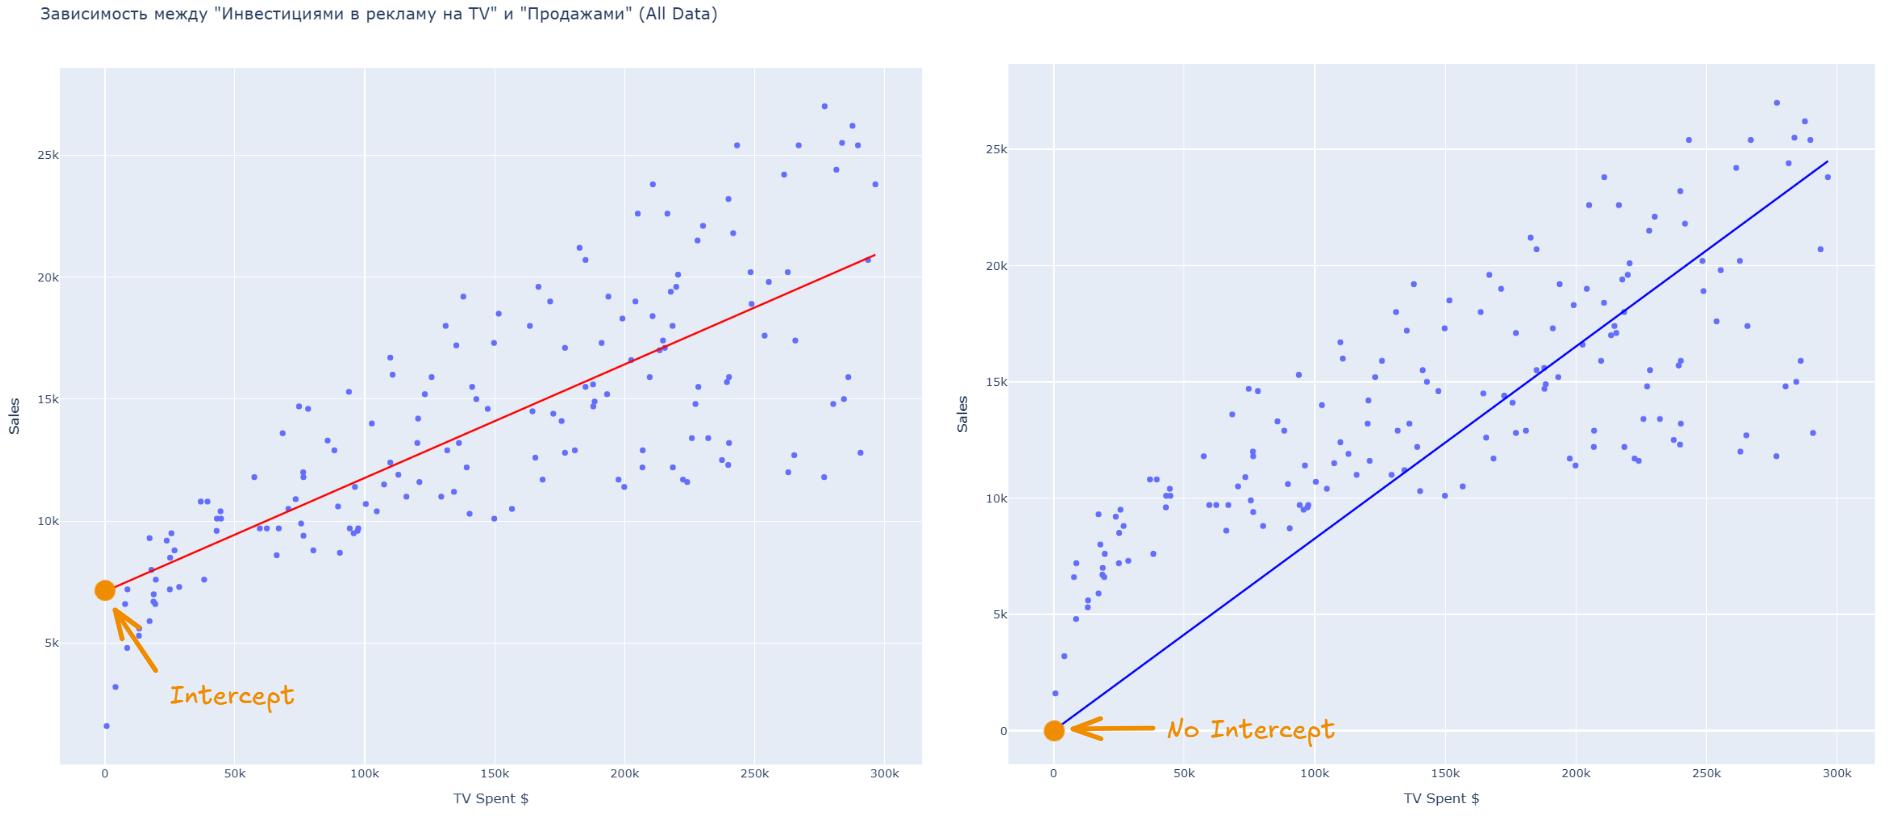

- Как видишь, на данной выборке модели без _intercept_ сложнее "зафититься", как следсвтие - хуже качество.

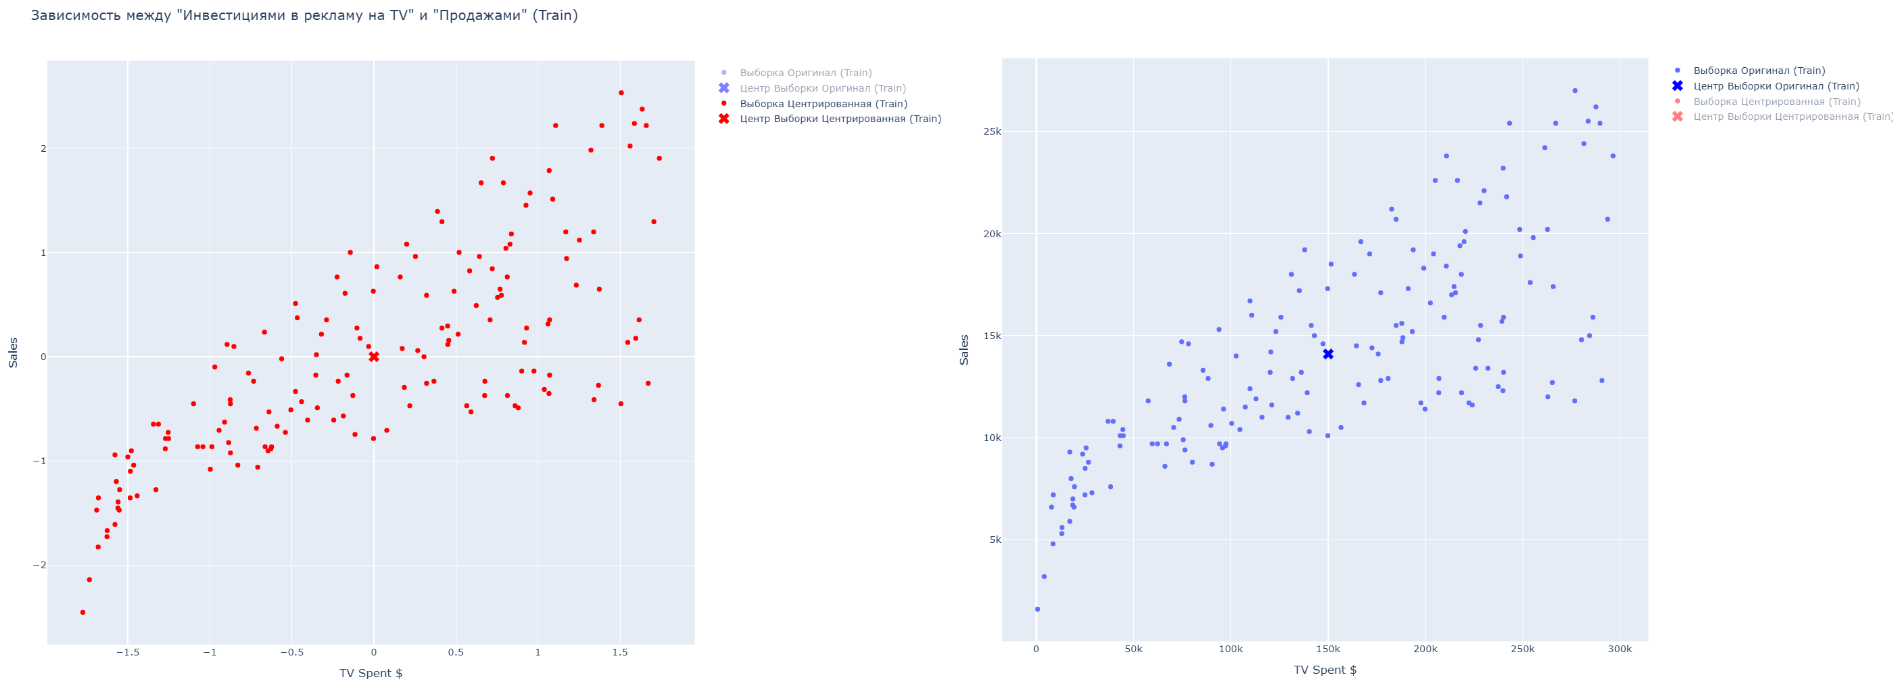

Хорошо видно, что при центрировании данных облако точек смещается в центр координат — там, где признаки равны нулю, выборка симметрична относительно нуля! В случае нецентрированных данных эта точка очень сильно смещена. Причём, чем больше выбросов в выборке, тем сильнее проявляется это смещение. 

Однако _intercept_ не всегда может быть равен среднему значению $y$, он может подобраться таким, чтобы с учётом влияния всех признаков модель как можно лучше аппроксимировала таргет $y$. Но есть важно НО! Если признаки центрированы - используется Z-преобразование, то $\bar{x}_j = 0$ и _intercept_ будет равен среднему значению таргета. Напомню, в нашей модели мы осуществляли центрирование выборки, значит _intercpet_ должен быть равен среднему значению таргета обучающей выборки. Проверим это:

In [71]:
print('Среднее значение продаж (Train): ', train_df['Sales'].mean())
print('Intercept модели: w0 -> ', regression_model.intercept_)

Среднее значение продаж (Train):  14100.0
Intercept модели: w0 ->  14100.0


Когда использовать _intercept_? 🤔
- Признаки не центрированы
    - В этом случае модель будет лучше аппроксимировать данные, не будет "жесткости"
- Таргет не центрирован
    - Модель не будет занижать/завышать прогноз, так как _intercept_ даст гибкость модели

Мы не всегда используем _StandardScaler_ или скейлим $y$, поэтому в 90% реальных случаев лучше использовать _intercept_, чтобы модели было проще подстроиться под данные. Можно не использовать _intercept_, если заранее известно, что при нулевых значениях признаков прогноз также должен быть равен нулю (например, из-за физических законов или бизнес-правил).

## Итоговая модель 🏁
Вот такой вид примет наша финальная модель на отмасштабированных данных:

$$
y = 14100 + 3772TV + 2803Radio + 57Newspaper -104Suburban - 52Uburban
$$

Полученные коэффициенты не подвержены влиянию масштаба признаков, так как мы применили масштабирование, и отражаются несмещенную оценку важности: _"TV"_, _"Radio"_, _"Suburban"_, _"Newspaper"_ и замыкает _"Urban"_.

Можно подумать, что если бы мы обучали отдельные модели на каждый признак, то получили бы точно такие же коэффициенты. Однако это не так! Теперь наша модель зависит от нескольких признаков, а значит и коэффициенты обучаются совместно!

На практиечких задача по ML очень любят строить графики важности используемых признаков, чтобы понять что сильнее всего вносит вклад в прогноз. Давай построим такой график для нашей финальной модели.

In [92]:
# визуализируем важность признаков

# первым делом создаем DataFrame с признаками и их важностью
feature_names = [
    'TV',
    'Radio',
    'Newspaper',
    'Suburban',
    'Urban'
]

feature_imp_df = pd.DataFrame({
    'feature_name': feature_names,
    'weight': regression_model.coef_.ravel()
})

feature_imp_df

,feature_name,weight
0,TV,3771.824706
1,Radio,2803.522512
2,Newspaper,57.109687
3,Suburban,-103.577122
4,Urban,-52.149550


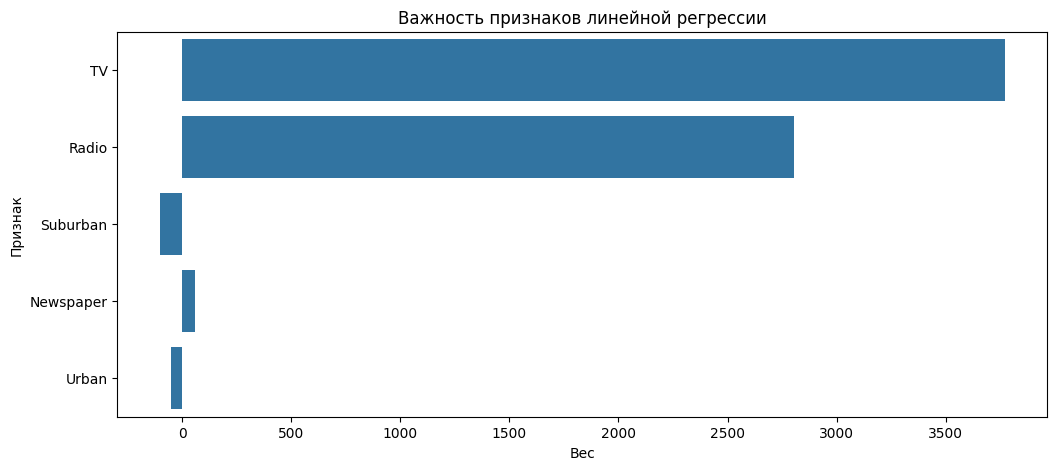

In [109]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))
sns.barplot(x='weight', y='feature_name', data=feature_imp_df)
plt.title('Важность признаков линейной регрессии')
plt.xlabel('Вес')
plt.ylabel('Признак')
plt.show()

- На графике сразу видно, что `TV` и `Radio` обладают самой большой важностью. Однако, так как веса могут быть положительными или отрицательными, то часто смотрят на абсолютную важность - так удобнее

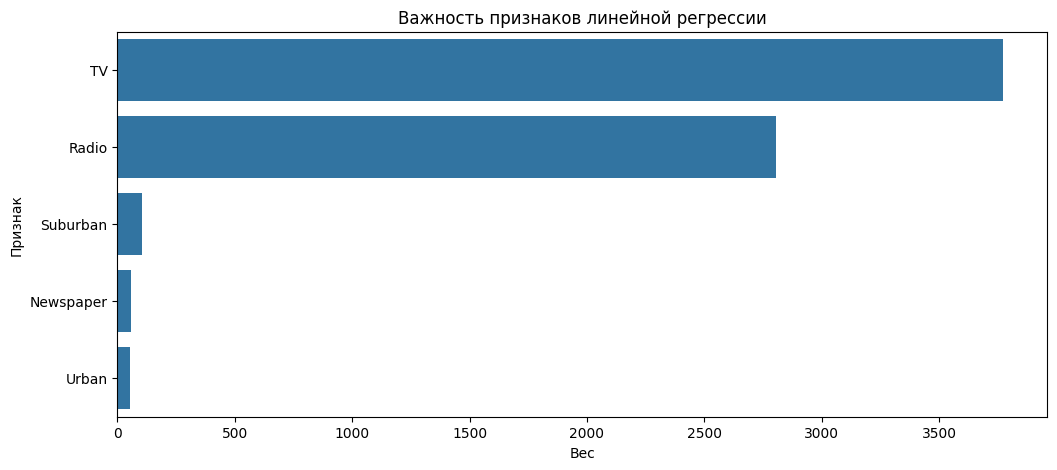

In [107]:
# построим график абсолютной важности фичей
feature_imp_df['weight_abs'] = feature_imp_df['weight'].abs()
feature_imp_df = feature_imp_df.sort_values('weight_abs', ascending=False)

plt.figure(figsize=(12,5))
sns.barplot(x='weight_abs', y='feature_name', data=feature_imp_df)
plt.title('Важность признаков линейной регрессии')
plt.xlabel('Вес')
plt.ylabel('Признак')
plt.show()

## О чем не было пока расказано? 💭
Так-как про линейные модели можно очень долго говорить и много чего изучать, то некотоыре моменты я решил пропустить, а именно:
- Влияние мультиколлинеарности
- Предположения модели линейной регрессии
- Оценка значимости коэффициентов
- Уверенность прогноза и доверительные интервалы
- Отбор признаков и анализ остатков

О этих деталях я подробно расскажу в рамках другой темы, пока не будем "пудрить" себе мозги 😵

### Задание 💪
Для закрепления материала, предлагаю тебе обучить модель многомерной регрессии для предсказания времени прослушивания подкаста
- [Данные](https://drive.google.com/drive/folders/1JoYrKXrPqoutbr5OqLHnvJb0WY4bl37G?usp=sharing)

Необходимо сделать следующие шаги 👣
- _Exploratory Data Analysis (EDA)_: признаки + построить графики зависимостей с целевой переменной
- Выбери метрику и обоснуй свой выбор
- Построение модели + валидация -> докажи что нет "переобучения"
- Сравни модель с _base-line_: необходимо указать эффект улучшения в % 
- Интерпретация модели:
    - Оценить важность признаков + построй график важности признаков
    - Продемонстрируй, что модель действительно выучила закономерности используемых признаков

- Придумай бизнес кейс, описывающий полезность данной модели. Как такая модель может быть полезна бизнесу? Для чего?


**Важно** ⚠️
- Оформи задание в отдельном ноутбуке!